In [1]:
import numpy as np

# Define the model mapping
groq_models = {
    "llama3-70b": "llama3-70b-8192",
    "mixtral": "mixtral-8x7b-32768",
    "gemma-7b": "gemma-7b-it",
    "llama3.1-70b": "llama-3.1-70b-versatile",
    "llama3-8b": "llama3-8b-8192",
    "llama3.1-8b": "llama-3.1-8b-instant",
    "gemma-9b": "gemma2-9b-it"
}

activity_labels = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}
reverse_activity_labels = {v: k for k, v in activity_labels.items()}

print("Activity Labels Dictionary: ", reverse_activity_labels)

# Load datasets
X_train = np.load('../FinalDataset/X_train.npy')
X_test = np.load('../FinalDataset/X_test.npy')
y_train = np.load('../FinalDataset/y_train.npy')
y_test = np.load('../FinalDataset/y_test.npy')

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

Activity Labels Dictionary:  {'WALKING': 1, 'WALKING_UPSTAIRS': 2, 'WALKING_DOWNSTAIRS': 3, 'SITTING': 4, 'STANDING': 5, 'LAYING': 6}
X_train shape:  (126, 500, 3)
X_test shape:  (54, 500, 3)
y_train shape:  (126,)
y_test shape:  (54,)


In [2]:
with np.load('processed_data.npz') as data:
    X_train_pca_20 = data['X_train_pca_20']
    X_test_pca_20 = data['X_test_pca_20']

In [3]:
print(X_train_pca_20.shape)
print(X_test_pca_20.shape)

(126, 20)
(54, 20)


## 6-SHOT

Test Case 1 (WALKING_DOWNSTAIRS):
Predicted label: 2
True label: 3
--------------------------------------------------
Test Case 2 (WALKING):
Predicted label: 2
True label: 1
--------------------------------------------------
Test Case 3 (WALKING_UPSTAIRS):
Predicted label: 2
True label: 2
--------------------------------------------------
Test Case 4 (STANDING):
Predicted label: 5
True label: 5
--------------------------------------------------
Test Case 5 (STANDING):
Predicted label: 5
True label: 5
--------------------------------------------------
Test Case 6 (WALKING):
Predicted label: 2
True label: 1
--------------------------------------------------
Test Case 7 (WALKING):
Predicted label: 2
True label: 1
--------------------------------------------------
Test Case 8 (STANDING):
Predicted label: 5
True label: 5
--------------------------------------------------
Test Case 9 (WALKING_DOWNSTAIRS):
Predicted label: 2
True label: 3
--------------------------------------------------
Tes

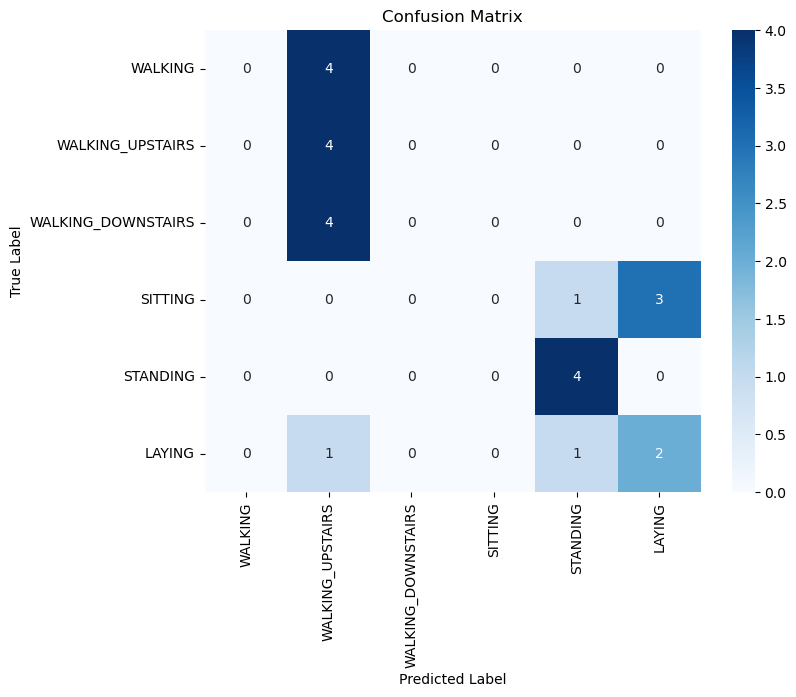

In [4]:
import time
from langchain_groq import ChatGroq
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to make API calls with retry logic for rate limit errors
def make_api_call(prompt):
    while True:
        try:
            response = llm.invoke(prompt)
            return response
        except Exception as e:
            print(f"Rate limit error: {e}. Retrying in 10 seconds...")
            time.sleep(10)

# Set up Groq API credentials and model
Groq_Token = "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"
model_name = "llama3.1-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)

# Select even samples for few-shot learning examples
samples_per_activity = 1
few_shot_indices = []
activity_count = {i: 0 for i in range(1, 7)}

for i, label in enumerate(y_train):
    if activity_count[label] < samples_per_activity:
        few_shot_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Create few-shot examples
few_shot_examples = [
    {"input": X_train_pca_20[i].tolist(), "label": y_train[i]} for i in few_shot_indices
]

# Function to create a few-shot learning prompt
def create_few_shot_prompt(examples, query_input):
    description = '''
        You are a highly trained human activity classification model.
        Each input is a vector containing numerical values that represent transformed features.
        The data consists of 20 principal components extracted from the Human Activity Recognition dataset.
        Your task is to classify the input vector into one of the following categories:
        - 1: WALKING
        - 2: WALKING_UPSTAIRS
        - 3: WALKING_DOWNSTAIRS
        - 4: SITTING 
        - 5: STANDING
        - 6: LAYING

        Here are a few examples:\n
    '''
    prompt = description
    for ex in examples:
        example_input = ",".join(map(str, ex['input']))
        prompt += f"Input: [{example_input}]\nLabel: {ex['label']}\n\n" 
        
    query_input_str = ",".join(map(str, query_input))
    prompt += f"Now, classify the following input vector and return ONLY the number.\nInput: [{query_input_str}]\nLabel: "
    return prompt

# Select 3 samples from each activity for testing
samples_per_activity = 3
selected_indices = []
activity_count = {i: 0 for i in range(1, 7)}

for i, label in enumerate(y_test):
    if activity_count[label] < samples_per_activity:
        selected_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Store predictions and true labels
predictions = []
true_labels = []

# Test the selected cases
for idx in selected_indices:
    query_input = X_test_pca_20[idx].tolist()
    true_label = y_test[idx]
    prompt = create_few_shot_prompt(few_shot_examples, query_input)
    
    # Make the API call and store the prediction
    answer = make_api_call(prompt)
    predicted_label = int(answer.content.strip())
    predictions.append(predicted_label)
    true_labels.append(true_label)
    
    # Print the predicted and true labels
    print(f"Test Case {idx + 1} ({activity_labels[true_label]}):")
    print(f"Predicted label: {predicted_label}")
    print(f"True label: {true_label}")
    print("-" * 50)

# Calculate and print accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions, labels=[1, 2, 3, 4, 5, 6])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], 
            yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## 12 -shot

In [6]:
import time
from langchain_groq import ChatGroq
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to make API calls with retry logic for rate limit errors
def make_api_call(prompt):
    while True:
        try:
            response = llm.invoke(prompt)
            return response
        except Exception as e:
            print(f"Rate limit error: {e}. Retrying in 10 seconds...")
            time.sleep(10)

# Set up Groq API credentials and model
Groq_Token = "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"
model_name = "llama3.1-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)

# Select even samples for few-shot learning examples
samples_per_activity = 2
few_shot_indices = []
activity_count = {i: 0 for i in range(1, 7)}

for i, label in enumerate(y_train):
    if activity_count[label] < samples_per_activity:
        few_shot_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Create few-shot examples
few_shot_examples = [
    {"input": X_train_pca_20[i].tolist(), "label": y_train[i]} for i in few_shot_indices
]

# Function to create a few-shot learning prompt
def create_few_shot_prompt(examples, query_input):
    description = '''
        You are a highly trained human activity classification model.
        Each input is a vector containing numerical values that represent transformed features.
        The data consists of 20 principal components extracted from the Human Activity Recognition dataset.
        Your task is to classify the input vector into one of the following categories:
        - 1: WALKING
        - 2: WALKING_UPSTAIRS
        - 3: WALKING_DOWNSTAIRS
        - 4: SITTING 
        - 5: STANDING
        - 6: LAYING

        Here are a few examples:\n
    '''
    prompt = description
    for ex in examples:
        example_input = ",".join(map(str, ex['input']))
        prompt += f"Input: [{example_input}]\nLabel: {ex['label']}\n\n" 
        
    query_input_str = ",".join(map(str, query_input))
    prompt += f"Now, classify the following input vector and return ONLY the number.\nInput: [{query_input_str}]\nLabel: "
    return prompt

# Select 3 samples from each activity for testing
samples_per_activity = 3
selected_indices = []
activity_count = {i: 0 for i in range(1, 7)}

for i, label in enumerate(y_test):
    if activity_count[label] < samples_per_activity:
        selected_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Store predictions and true labels
predictions = []
true_labels = []

# Test the selected cases
for idx in selected_indices:
    query_input = X_test_pca_20[idx].tolist()
    true_label = y_test[idx]
    prompt = create_few_shot_prompt(few_shot_examples, query_input)
    
    # Make the API call and store the prediction
    answer = make_api_call(prompt)
    predicted_label = int(answer.content.strip())
    predictions.append(predicted_label)
    true_labels.append(true_label)
    
    # Print the predicted and true labels
    print(f"Test Case {idx + 1} ({activity_labels[true_label]}):")
    print(f"Predicted label: {predicted_label}")
    print(f"True label: {true_label}")
    print("-" * 50)

# Calculate and print accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions, labels=[1, 2, 3, 4, 5, 6])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], 
            yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Rate limit error: Error code: 400 - {'error': {'message': 'Organization has been restricted. Please reach out to support if you believe this was in error.', 'type': 'invalid_request_error', 'code': 'organization_restricted'}}. Retrying in 10 seconds...


KeyboardInterrupt: 